# NFL Defensive Formation Preprocessing (Memory-Efficient)

Memory efficient pipeline for limited RAM laptops

**Key optimizations:**
- Processes one week at a time (not all 17 weeks simultaneously)
- Keeps only essential columns
- Filters to pass plays early to reduce data size
- You can choose how many weeks to process

Start with 2-3 weeks, then scale up as needed.

In [30]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from preprocessing_lite import NFLDataPreprocessorLite, save_point_clouds, load_point_clouds
from visualization import NFLFieldVisualizer, validate_preprocessing

%matplotlib inline
plt.style.use('default')

## Initialize Preprocessor

In [31]:
# Initialize preprocessor
preprocessor = NFLDataPreprocessorLite("../data/raw")

## Choose Which Weeks to Process

**Options:**
- **Small test**: `weeks=[1]` or `weeks=[1, 2]`
- **Medium dataset**: `weeks=[1, 2, 3, 4, 5]`
- **Full dataset**: `weeks=None` (all 17 weeks - requires more memory)

Each week contains ~1000 pass plays, so:
- 1 week ≈ 1,000 plays
- 5 weeks ≈ 5,000 plays
- 17 weeks ≈ 17,000 plays

In [32]:
# Start with just 2 weeks to test
WEEKS_TO_PROCESS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

# Once this works, increase to more weeks:
# WEEKS_TO_PROCESS = [1, 2, 3, 4, 5]
# WEEKS_TO_PROCESS = None  # All weeks (requires more RAM)

## Run Preprocessing

In [ ]:
# Process the selected weeks
defensive_df, point_clouds = preprocessor.preprocess_multiple_weeks(weeks=WEEKS_TO_PROCESS)

Loading metadata files...
  Checking available columns...
  Loading 22 columns...
  Loaded 19237 pass plays
Loaded 253 games

Processing 17 weeks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

Processing Week 1...
  Checking available columns...
  Loading tracking data (17 columns)...
  Loaded 986022 tracking records


## Inspect Results

In [ ]:
# Check dataframe
print(f"Defensive DataFrame shape: {defensive_df.shape}")
print(f"Number of plays: {len(point_clouds)}")
print(f"\nColumns: {list(defensive_df.columns)}")
print(f"\nFirst few rows:")
defensive_df.head()

Defensive DataFrame shape: (65868, 23)
Number of plays: 8569

Columns: ['time', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'nflId', 'displayName', 'jerseyNumber', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'possessionTeam', 'passResult', 'down', 'yardsToGo', 'offenseFormation', 'defendersInTheBox']

First few rows:


,time,x,y,s,a,dis,o,dir,event,nflId,...,team,gameId,playId,playDirection,possessionTeam,passResult,down,yardsToGo,offenseFormation,defendersInTheBox
0,2018-09-07T01:07:18.099Z,35.18,14.97,5.53,4.30,0.54,115.34,138.58,pass_forward,79848.0,...,home,2018090600,75,left,ATL,C,1,15,I_FORM,7.0
1,2018-09-07T01:07:18.099Z,33.98,34.66,3.52,0.69,0.35,208.19,36.15,pass_forward,2495613.0,...,home,2018090600,75,left,ATL,C,1,15,I_FORM,7.0
2,2018-09-07T01:07:18.099Z,50.37,22.49,2.93,2.65,0.30,259.24,135.98,pass_forward,2534832.0,...,home,2018090600,75,left,ATL,C,1,15,I_FORM,7.0
3,2018-09-07T01:07:18.099Z,33.90,19.77,3.75,1.49,0.37,232.23,131.29,pass_forward,2552315.0,...,home,2018090600,75,left,ATL,C,1,15,I_FORM,7.0
4,2018-09-07T01:07:18.099Z,40.49,33.30,2.99,0.69,0.30,258.25,79.75,pass_forward,2552689.0,...,home,2018090600,75,left,ATL,C,1,15,I_FORM,7.0


In [ ]:
# Check point clouds
print(f"Number of plays with formations: {len(point_clouds)}")

if len(point_clouds) > 0:
    sample_formation = list(point_clouds.values())[0]
    print(f"Sample formation shape: {sample_formation.shape}")
    print(f"\nAverage defenders per play: {np.mean([pc.shape[0] for pc in point_clouds.values()]):.1f}")
    print(f"Min defenders: {min([pc.shape[0] for pc in point_clouds.values()])}")
    print(f"Max defenders: {max([pc.shape[0] for pc in point_clouds.values()])}")

Number of plays with formations: 8569
Sample formation shape: (7, 2)

Average defenders per play: 7.7
Min defenders: 5
Max defenders: 11


## Visualize Sample Formations

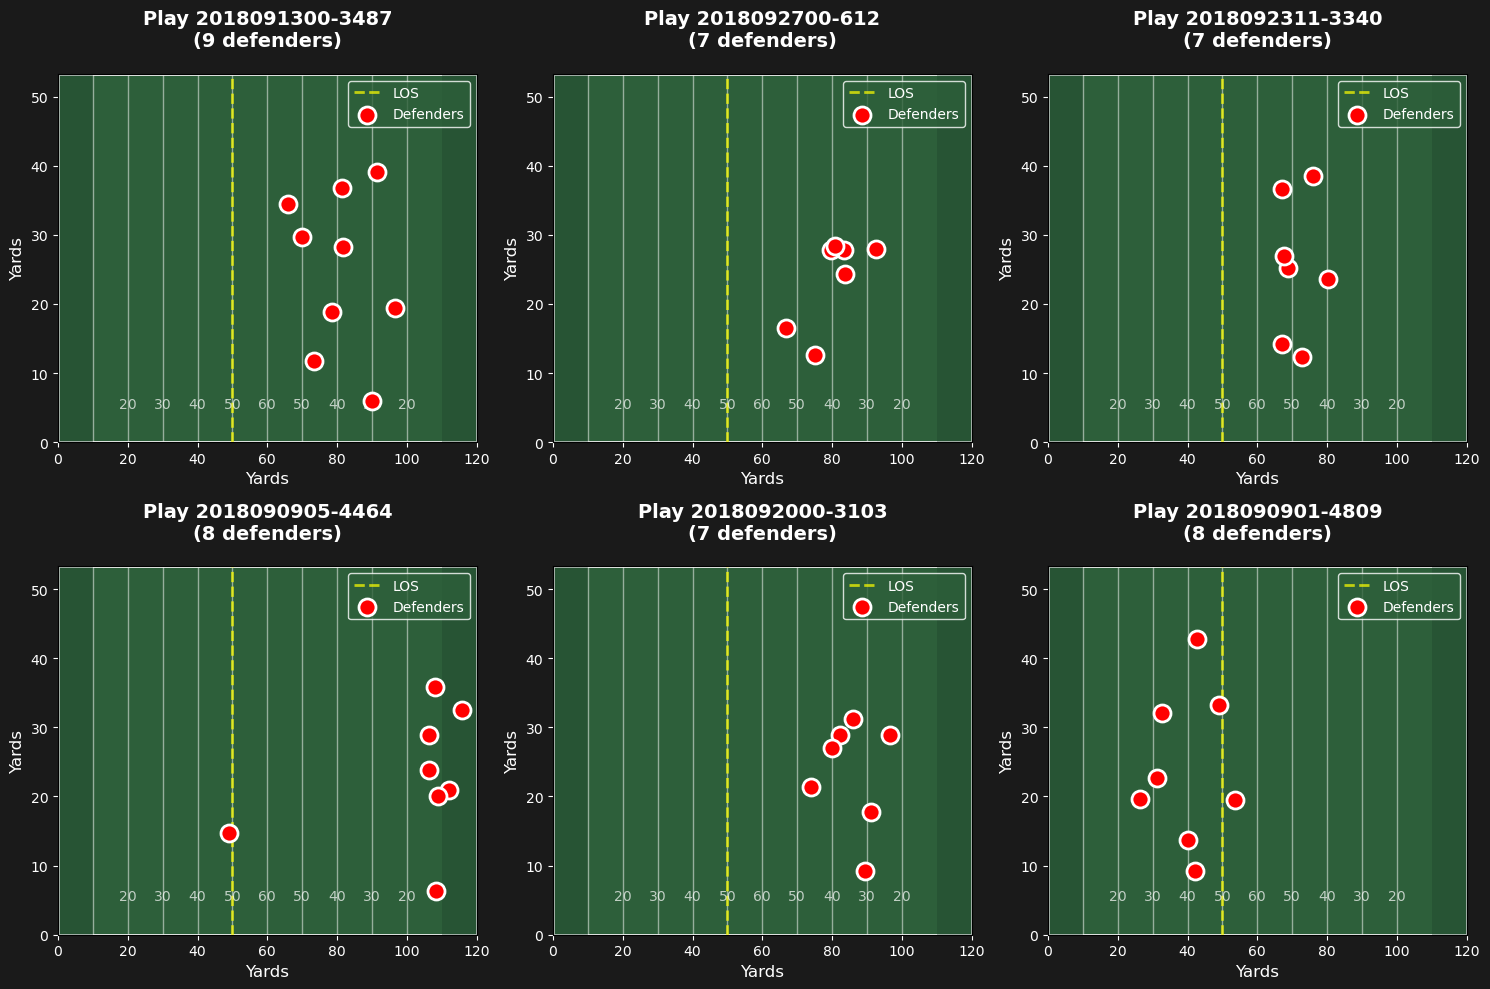

In [ ]:
# Create visualizer
visualizer = NFLFieldVisualizer()

# Plot 6 sample formations
fig = visualizer.plot_multiple_formations(point_clouds, n_samples=6)
plt.show()

## Formation Statistics

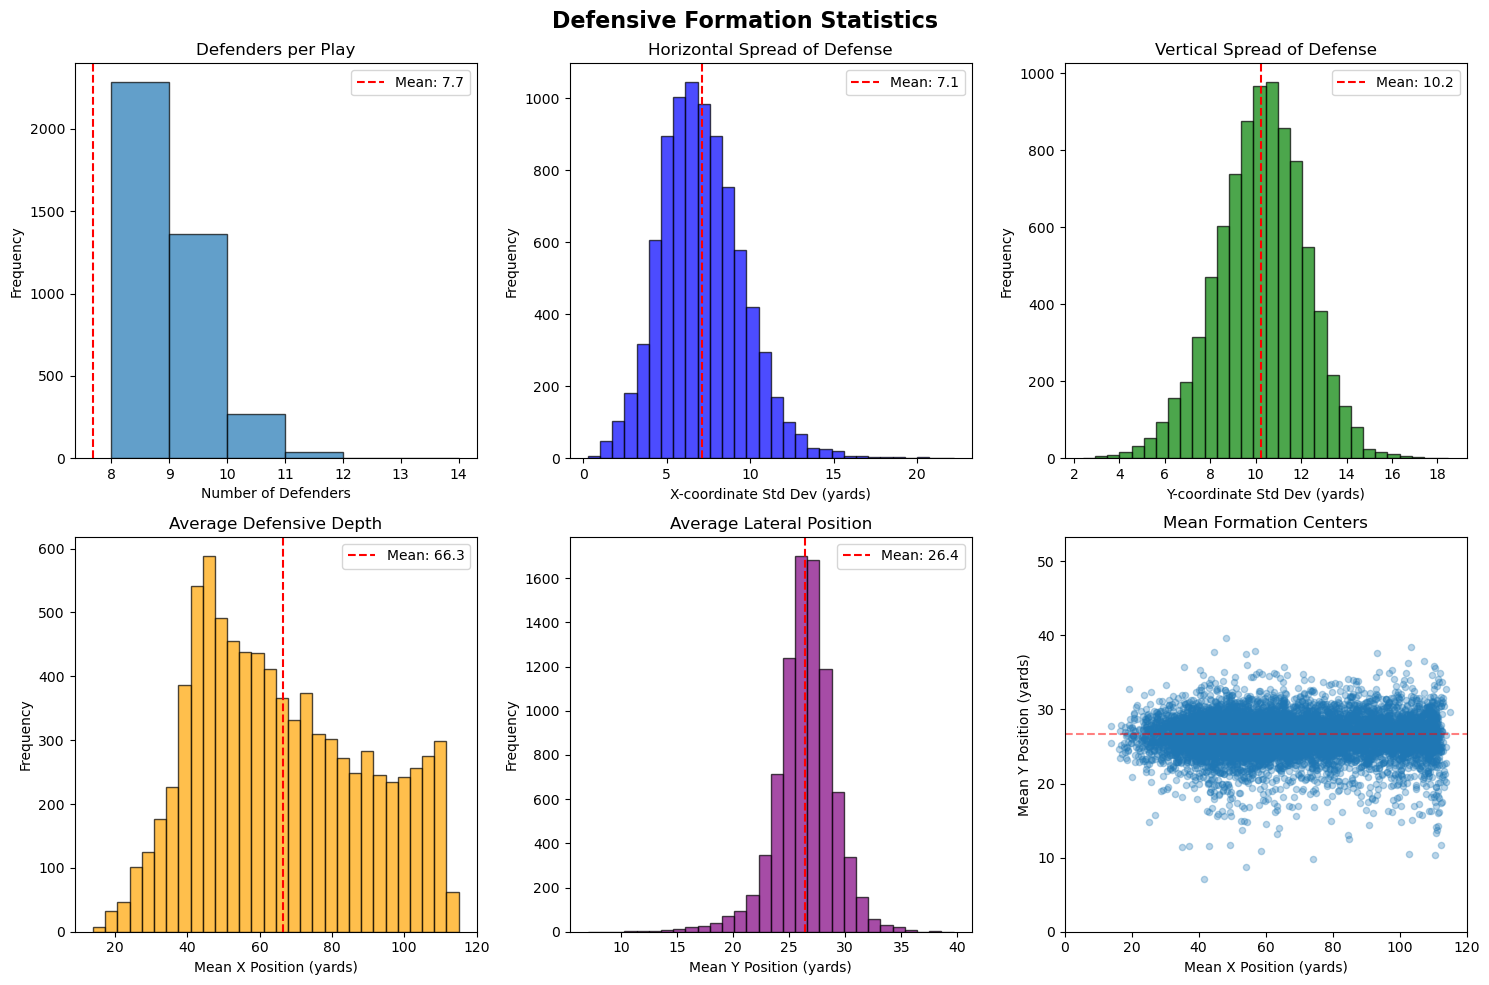

In [ ]:
# Plot statistical distributions
fig = visualizer.plot_formation_statistics(point_clouds)
plt.show()

## Examine a Single Formation in Detail

In [ ]:
# Pick a random play to examine in detail
sample_play_id = list(point_clouds.keys())[150]
sample_formation = point_clouds[sample_play_id]

print(f"Play: Game {sample_play_id[0]}, Play {sample_play_id[1]}")
print(f"Number of defenders: {sample_formation.shape[0]}")

# Get defender details from the dataframe
play_defenders = defensive_df[
    (defensive_df['gameId'] == sample_play_id[0]) & 
    (defensive_df['playId'] == sample_play_id[1])
].copy()

# Sort by position to match point cloud order
play_defenders = play_defenders.sort_values(['x', 'y']).reset_index(drop=True)

print(f"\nDefenders on this play:")
print("=" * 70)
for i, row in play_defenders.iterrows():
    name = row['displayName'] if 'displayName' in row else f"Player {i+1}"
    jersey = f"#{int(row['jerseyNumber'])}" if 'jerseyNumber' in row and pd.notna(row['jerseyNumber']) else ""
    team = row['team'] if 'team' in row else ""
    pos = f"({row['x']:.1f}, {row['y']:.1f})"
    print(f"  {i+1:2}. {name:20s} {jersey:5s} {team:6s} at {pos}")

print(f"\nDefender positions (x, y) array:")
print(sample_formation)

Play: Game 2018090900, Play 901
Number of defenders: 7

Defenders on this play:
   1. Lorenzo Alexander    #57   away   at (103.7, 23.8)
   2. Matt Milano          #58   away   at (105.2, 31.8)
   3. Tremaine Edmunds     #49   away   at (105.3, 28.7)
   4. Phillip Gaines       #28   away   at (109.1, 17.2)
   5. Jordan Poyer         #21   away   at (109.9, 36.0)
   6. Tre'Davious White    #27   away   at (110.9, 13.9)
   7. Micah Hyde           #23   away   at (111.8, 21.8)

Defender positions (x, y) array:
[[103.68  23.78]
 [111.81  21.78]
 [109.89  36.02]
 [109.12  17.16]
 [110.9   13.95]
 [105.19  31.78]
 [105.27  28.7 ]]


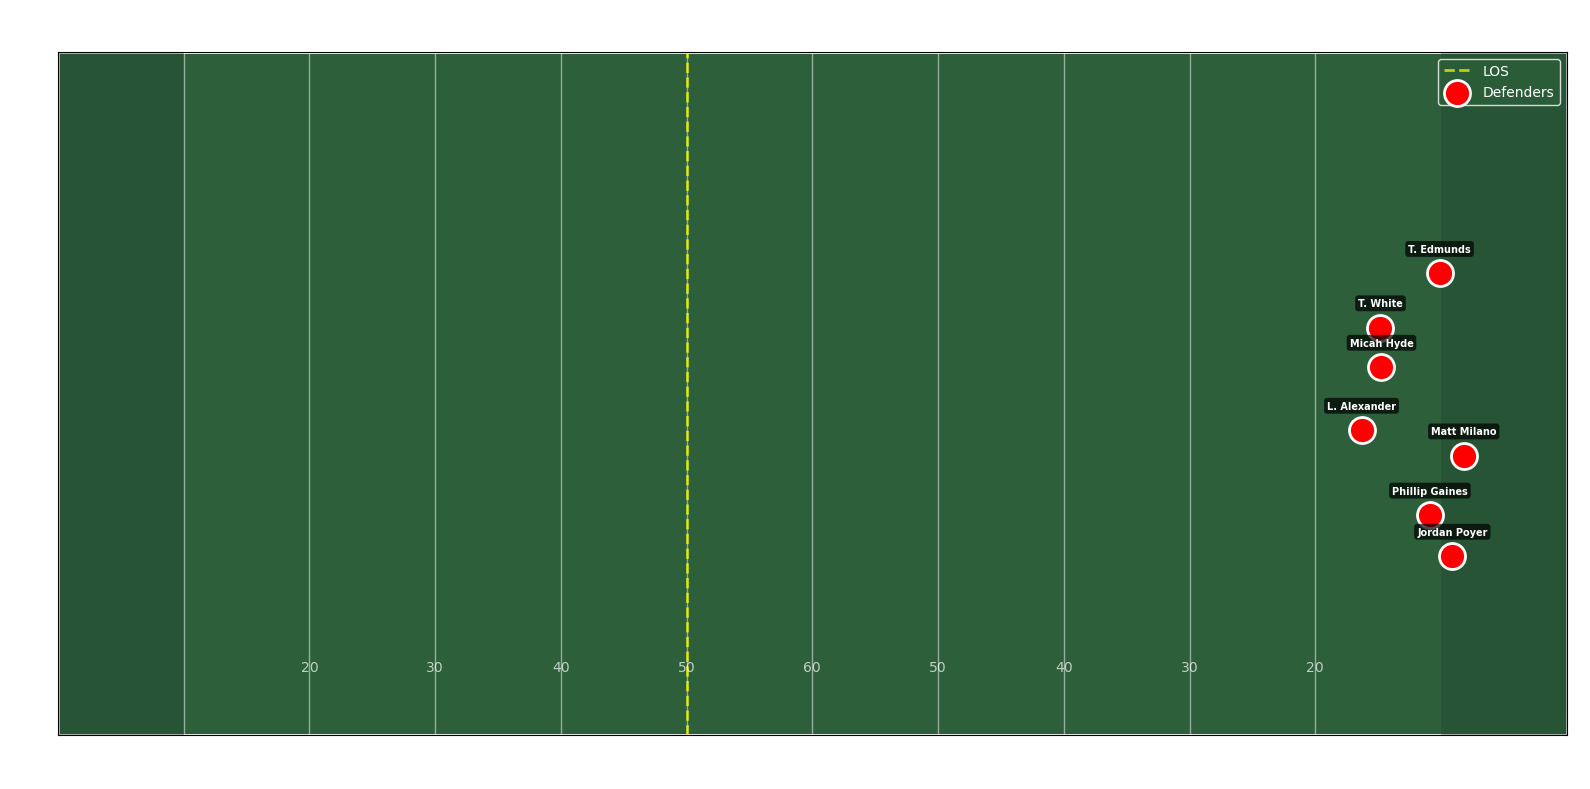

In [ ]:
# Get defender names for visualization
defender_names = []
if 'displayName' in play_defenders.columns:
    for _, row in play_defenders.iterrows():
        name = row['displayName']
        # Shorten name for display
        if pd.notna(name) and len(name) > 15:
            parts = name.split()
            name = f"{parts[0][0]}. {parts[-1]}" if len(parts) > 1 else name[:12]
        defender_names.append(name if pd.notna(name) else f"Player")

# Visualize this formation with player names
fig, ax = plt.subplots(figsize=(16, 8))
visualizer.plot_formation(
    sample_formation,
    ax=ax,
    title=f"Defensive Formation with Names - Game {sample_play_id[0]}, Play {sample_play_id[1]}",
    player_names=defender_names if defender_names else None,
    player_size=350
)
plt.tight_layout()
plt.show()

## Analyze by Play Outcome

Check if there are differences in formations for completed vs incomplete passes.

In [ ]:
# Check pass results distribution
if 'passResult' in defensive_df.columns:
    print("Pass result distribution:")
    print(defensive_df.groupby('passResult')['playId'].nunique())
    
    # Calculate average formation spread by outcome
    play_outcomes = defensive_df[['gameId', 'playId', 'passResult']].drop_duplicates()
    
    spreads = []
    for (game_id, play_id), pc in point_clouds.items():
        outcome_row = play_outcomes[
            (play_outcomes['gameId'] == game_id) & 
            (play_outcomes['playId'] == play_id)
        ]
        if len(outcome_row) > 0:
            outcome = outcome_row['passResult'].values[0]
            x_spread = np.std(pc[:, 0])
            y_spread = np.std(pc[:, 1])
            spreads.append({'outcome': outcome, 'x_spread': x_spread, 'y_spread': y_spread})
    
    spreads_df = pd.DataFrame(spreads)
    
    print("\nAverage formation spread by outcome:")
    print(spreads_df.groupby('outcome')[['x_spread', 'y_spread']].mean())

Pass result distribution:
passResult
C     3120
I     2133
IN     198
S        2
Name: playId, dtype: int64

Average formation spread by outcome:
         x_spread   y_spread
outcome                     
C        6.897897  10.149209
I        7.478869  10.331889
IN       7.283656  10.392713
S        8.315674   5.941690


## Save Processed Data

In [ ]:
# Save defensive formations dataframe
defensive_df.to_csv("../data/processed/defensive_formations.csv", index=False)
print("✓ Saved defensive formations CSV")

# Save point clouds
save_point_clouds(point_clouds, "../data/processed/point_clouds.npy")
print("✓ Saved point clouds")

print(f"\nProcessed {len(point_clouds)} plays from {len(WEEKS_TO_PROCESS) if WEEKS_TO_PROCESS else 17} weeks")

✓ Saved defensive formations CSV
Saved point clouds to ../data/processed/point_clouds.npy
✓ Saved point clouds

Processed 8569 plays from 8 weeks


## Generate Validation Plots

Creating validation visualizations...
Saved sample formations to ../results/figures/preprocessing/sample_formations.png
Saved formation statistics to ../results/figures/preprocessing/formation_statistics.png
Saved coordinate distribution to ../results/figures/preprocessing/coordinate_distribution.png

Validation complete! Review the plots to confirm preprocessing.
Total plays processed: 8569
Total defensive player positions: 65868

✓ All validation plots saved to results/figures/preprocessing/


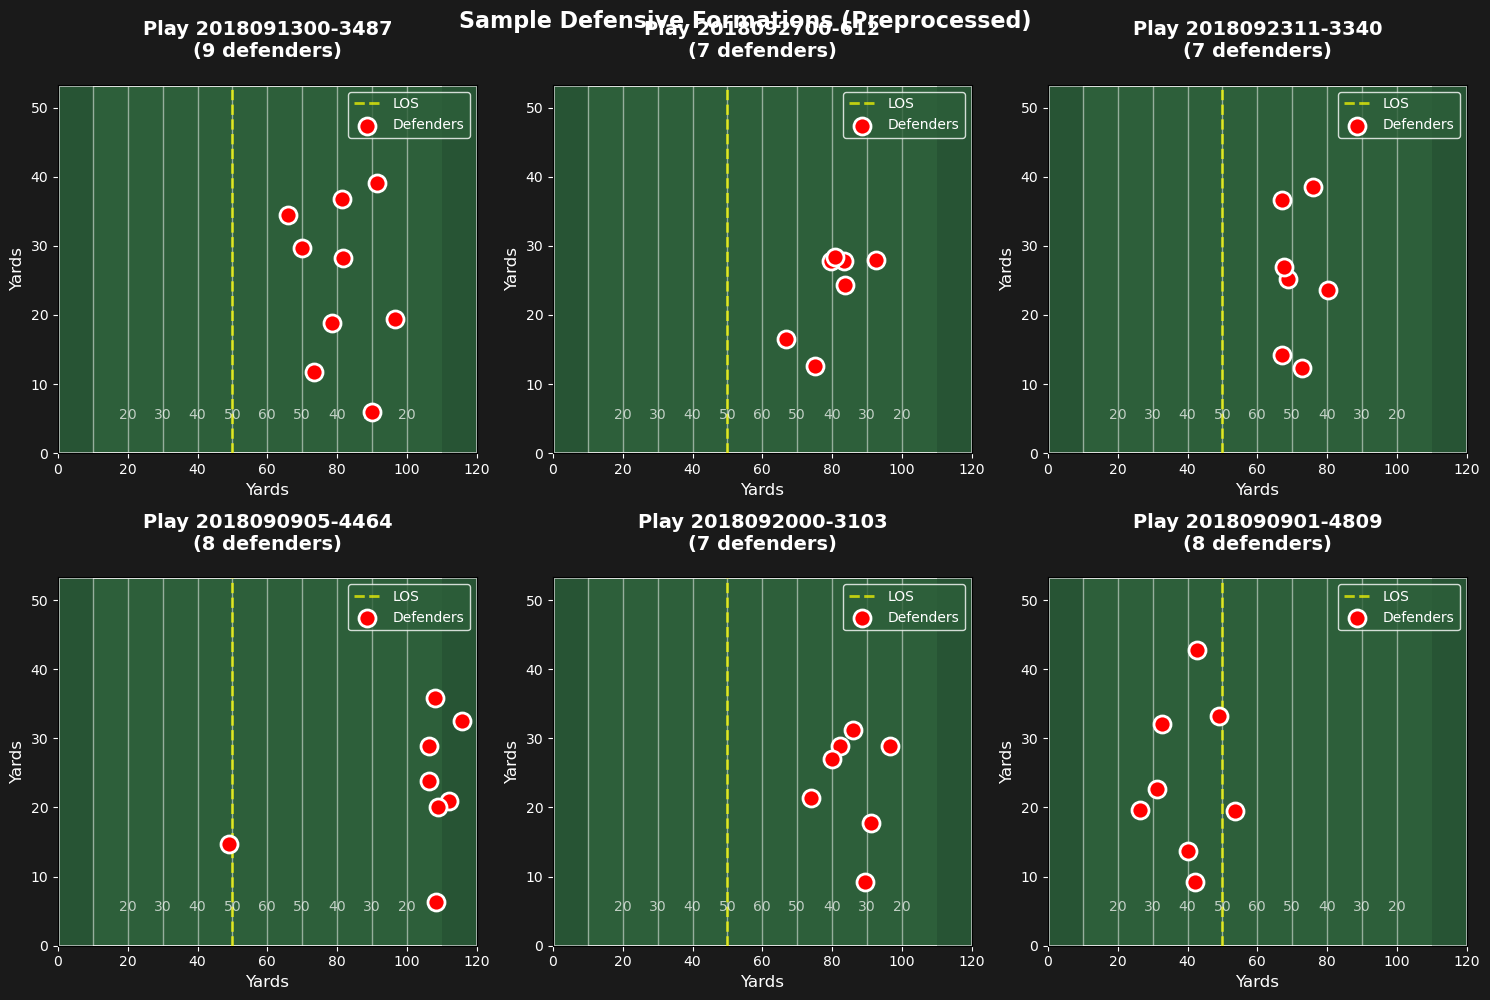

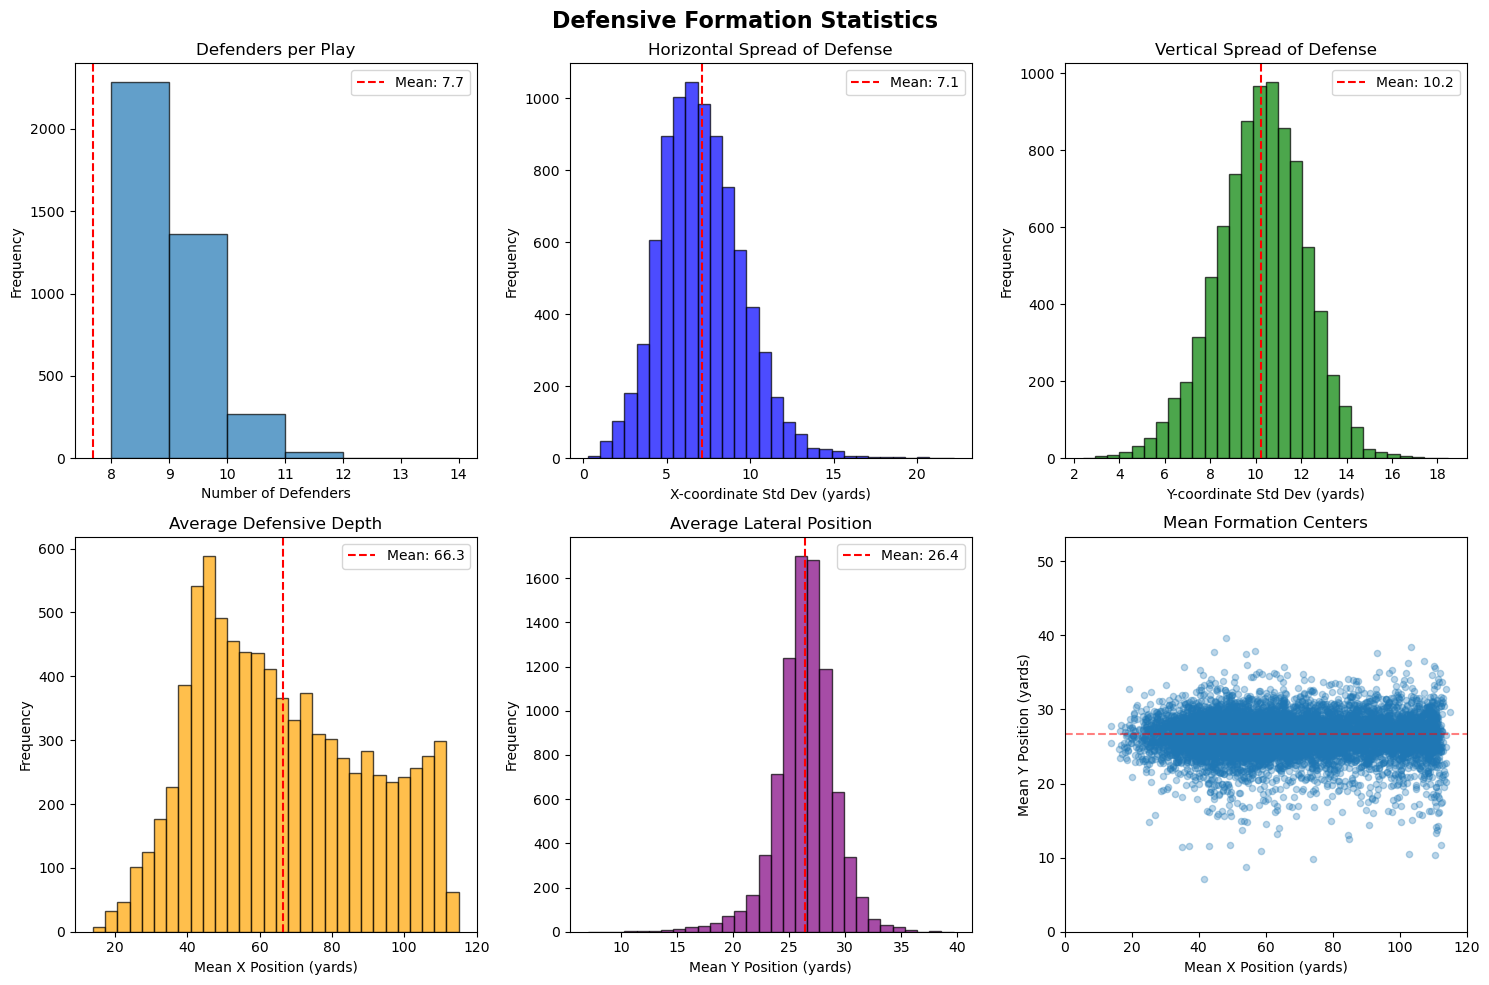

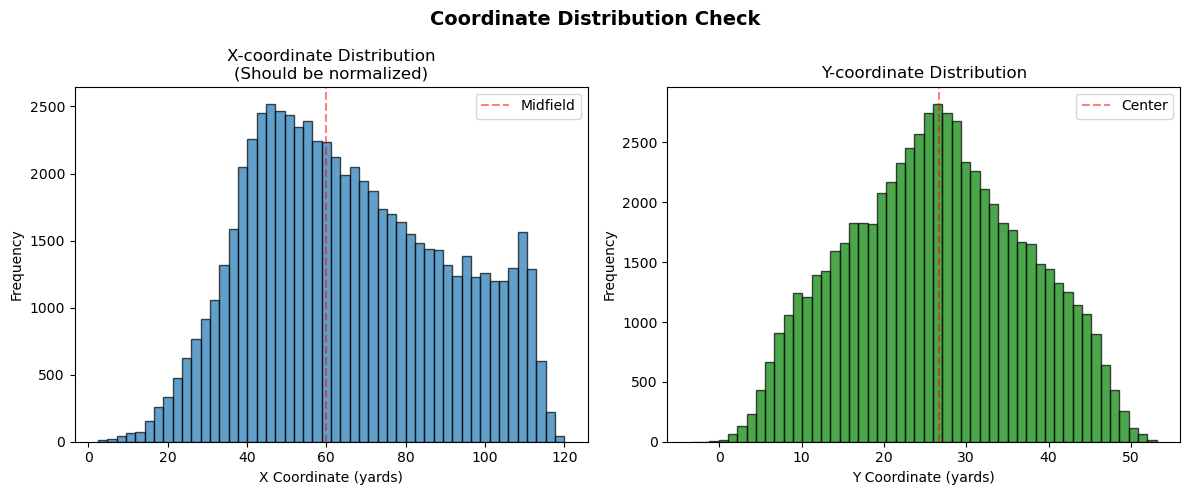

In [ ]:
# Generate and save all validation plots
validate_preprocessing(
    defensive_df,
    point_clouds,
    output_dir="../results/figures/preprocessing"
)

print("\n✓ All validation plots saved to results/figures/preprocessing/")

## Process Additional Weeks

To add more weeks without restarting, process them individually:

In [ ]:
# Example: Add week 3 to existing data
# defensive_df_week3, point_clouds_week3 = preprocessor.process_week(3)

# # Combine with existing data
# defensive_df = pd.concat([defensive_df, defensive_df_week3], ignore_index=True)
# point_clouds.update(point_clouds_week3)

# print(f"Total plays now: {len(point_clouds)}")